## Read in the Data & First Glance

In [30]:
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils import to_categorical
from keras.datasets import mnist
from sklearn.neighbors import KNeighborsClassifier


# Importing data from Kaggle competition
data = pd.read_csv('digit-recognizer/train.csv')
# test = pd.read_csv('digit-recognizer/test.csv')
# print(data.shape)


# Importing data from keras
# Resource: https://keras.io/datasets/#mnist-database-of-handwritten-digits
(X_train, y_train), (X_test, y_test) = mnist.load_data()
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(60000, 28, 28)
(60000,)
(10000, 28, 28)
(10000,)


In [ ]:
# can change directory, if you want
data_dir = 'plagiarism_data'

"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""

make_csv(train_x, train_y, filename='train.csv', data_dir=data_dir)
make_csv(test_x, test_y, filename='test.csv', data_dir=data_dir)

After I read in the data I realized that since this is a Kaggle competition, the test set doesn't have any labels to be able to verify the accuracy that our model performed on. We need the label to verify what the model predicted to what the actual label should be classified as. So instead of using the MNIST dataset provided on the Kaggle site, I will download the dataset from keras itself. They have it available in their datasets for importing right into the notebook. 

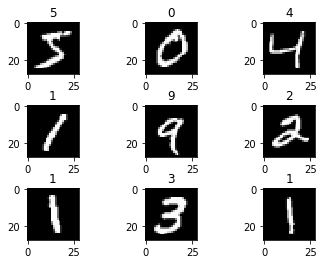

In [56]:
# Let's view a couple images
for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.subplots_adjust(hspace=.6)
    plt.imshow(X_train[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.title(y_train[i])

Text(0.5, 1.0, 'Frequency of Classification of Numbers')

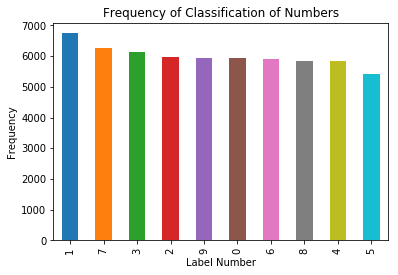

In [69]:
train_labels = pd.DataFrame(y_train)
train_labels.rename(columns={0: 'label'}, inplace=True)
train_labels['label'].value_counts().plot.bar()
plt.xlabel('Label Number')
plt.ylabel('Frequency')
plt.title('Frequency of Classification of Numbers')

## Preprocess the Data

Preprocess the data so that the model can better intake the images for prediction. We will need to one-hot encode the labels and normalize the images a bit. 

In [19]:
# One-hot encode the label since there are 10 categories (aka- numbers 0 thru 10)
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [20]:
# reshape to account for dimensionality and have single channel
X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test.reshape(X_test.shape[0], 28, 28, 1)
print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [21]:
# Convert data accordingly
X_train = X_train.astype('float')
y_train = y_train.astype('int')
X_test = X_test.astype('float')
y_test = y_test.astype('int')

In [31]:
# Convert 3D data into 2D dataset
# Resource: https://stackoverflow.com/questions/34972142/sklearn-logistic-regression-valueerror-found-array-with-dim-3-estimator-expec
nsamples, nx, ny = X_train.shape
X_train_lowdim = X_train.reshape((nsamples,nx*ny))
print(X_train_lowdim.shape)

nsamples, nx, ny = X_test.shape
X_test_lowdim = X_test.reshape((nsamples,nx*ny))
print(X_test_lowdim.shape)

(60000, 784)
(10000, 784)


## Benchmark Model

I will need to transform the data into a lower dimension in order to run the SVC model against the data. It requires intaking 2D data instead of the reshaped 3D data to account for the pixel size of (28, 28). 

In [40]:
# Benchmark how SVC performs on greyscale images
%%time

start_time = time.time()

svc_model = SVC(random_state=42)
svc_model.fit(X_train_lowdim, y_train.ravel())
score = svc_model.score(X_test_lowdim, y_test)

print("Accuracy for SVC model  rows: %s" % score)
print("--- %s seconds ---" % round((time.time() - start_time), 2))

/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


Accuracy for SVC model  rows: 0.1135
--- 14130.29 seconds ---


Ok, so this model didn't perform that well, but at least we have a benchmark point that we can aim to improve upon when creating our model from scratch. We will next try to apply the k-nearest neighbors algorithm to achieve better performance.

## Defining the Model

Now it's time to create a model to compete against the benchmark model. I'm going to try to apply a k-nearest neighbor model to better predict the classification of the digit images. But first we need to figure out the optimal k-value.

In [32]:
print(X_train_lowdim.shape)
print(y_train.shape)

(60000, 784)
(60000,)


In [33]:
# Split data further so that we have a validation set 
Xval_train, Xval_test, yval_train, y_val_test = train_test_split(X_train_lowdim, y_train, test_size=0.1, random_state=45)
print(Xval_train.shape)
print(yval_train.shape)
print(Xval_test.shape)
print(y_val_test.shape)

(54000, 784)
(54000,)
(6000, 784)
(6000,)


In [35]:
# Here we want to decide which k-value will give us the best result
kVals = range(1, 30, 2)
accuracies = []

# loop over different kVals
for k in kVals:
    # use k-value to train the model
    model = KNeighborsClassifier(n_neighbors=k)
    model.fit(Xval_train, yval_train)

    # score the model
    score = model.score(Xval_test, y_val_test)
    print("k=%d, accuracy=%.2f%%" % (k, score * 100))
    accuracies.append(score)

# printing best k for highest accuracy
i = np.argmax(accuracies)
print("k=%d achieved highest accuracy of %.2f%% on validation data" % (kVals[i], accuracies[i] * 100))

k=1, accuracy=97.32%
k=3, accuracy=97.27%
k=5, accuracy=97.12%
k=7, accuracy=96.93%
k=9, accuracy=96.70%
k=11, accuracy=96.58%
k=13, accuracy=96.48%
k=15, accuracy=96.33%
k=17, accuracy=96.17%
k=19, accuracy=96.07%
k=21, accuracy=95.97%
k=23, accuracy=95.73%
k=25, accuracy=95.77%
k=27, accuracy=95.65%
k=29, accuracy=95.52%
k=1 achieved highest accuracy of 97.32% on validation data


In [38]:
# Train and predict model using best k-value found previously
model = KNeighborsClassifier(n_neighbors=kVals[i])
model.fit(X_train_lowdim, y_train)

# Predict numbers
predictions = model.predict(X_test_lowdim)

# Evaluate performance for each classification
print("EVALUATION OF TESTING DATA:")
print(classification_report(y_test, predictions))

EVALUATION ON TESTING DATA
              precision    recall  f1-score   support

           0       0.98      0.99      0.99       980
           1       0.97      0.99      0.98      1135
           2       0.98      0.96      0.97      1032
           3       0.96      0.96      0.96      1010
           4       0.97      0.96      0.97       982
           5       0.95      0.96      0.96       892
           6       0.98      0.99      0.98       958
           7       0.96      0.96      0.96      1028
           8       0.98      0.94      0.96       974
           9       0.96      0.96      0.96      1009

    accuracy                           0.97     10000
   macro avg       0.97      0.97      0.97     10000
weighted avg       0.97      0.97      0.97     10000



I'm extremely surprised that the k-value that was most optimal ended up being k=1, but I'm very happy with the results. Overall, the model was able to perform great for accuracy for all classes. As a bonus, we were able to get good recall on all the classes too which means the model has more coverage over the cases of images it encounters. Essentially, accuracy points to the number of times the model can accurately classify a number, but within that number, the recall tells the number of cases it's accurately able to cover. 

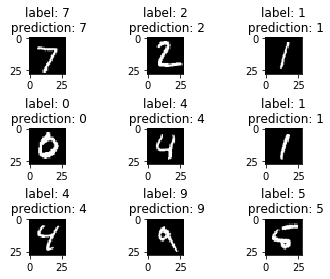

In [58]:
# Visualizing the model's results
for i in range(0, 9):
    plt.subplot(330 + (i+1))
    plt.subplots_adjust(hspace=1.5)
    plt.imshow(X_test[i].reshape(28, 28), cmap=plt.get_cmap('gray'))
    plt.title('label: ' + str(y_test[i]) + '\n prediction: ' + str(predictions[i]))


So above we can see some of the images from the test set that the model predicted classifications of. I printed off the actual label itself and what the model predicted. We see that the model is predicting what we would expect. Cool to actually see it in action!